In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('../../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Experiments

Here we showcase 3 types of experiments:

* **Hyperparameter optimization** for training of a model (*using Optuna*) **[not ready yet]**

* **Adversarial Training** of a model for different hyperparameters

* Evaluation of **Adversarial Attacks**


Preconditions:

* you need a ***PL-Module*** that specifies your model class and dataset!

# Training of a Model

* define your hyperparameters in `hparams`
* create your instance of `PLModule`
* define a trainer (e.g., define max epochs, ...)
* fit your model!

In [2]:
import numpy as np
import torch
import time
import pytorch_lightning as pl
from pytorch_lightning import loggers
import config

In [3]:
from classification.models.M5 import M5, M5PLModule

hparams = {
    "batch_size": 64,
    "learning_rate": 3e-4,
    "weight_decay": 0.001,
    "lr_decay": 0.95
}

model = M5PLModule(hparams)
model.prepare_data()

Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


In [4]:
trainer = pl.Trainer(
    max_epochs = 1,
    logger = loggers.TensorBoardLogger(config.LOG_DIR, name="M5"),
    gpus = 1 if torch.cuda.is_available() else None,
    log_gpu_memory = 'all'
)

trainer.fit(model)
model.save("./" + str(int(time.time())) + ".p")

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)


Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------------------
0  | model          | M5           | 555 K 
1  | model.model    | Sequential   | 555 K 
2  | model.model.0  | Conv1d       | 10 K  
3  | model.model.1  | BatchNorm1d  | 256   
4  | model.model.2  | MaxPool1d    | 0     
5  | model.model.3  | Dropout      | 0     
6  | model.model.4  | Conv1d       | 49 K  
7  | model.model.5  | BatchNorm1d  | 256   
8  | model.model.6  | MaxPool1d    | 0     
9  | model.model.7  | Dropout      | 0     
10 | model.model.8  | Conv1d       | 98 K  
11 | model.model.9  | BatchNorm1d  | 512   
12 | model.model.10 | MaxPool1d    | 0     
13 | model.model.11 | Dropout      | 0     
14 | model.model.12 | Conv1d       | 393 K 
15 | model.model.13 | BatchNorm1d  | 1 K   
16 | model.model.14 | MaxPool1d    | 0     
17 | model.model.15 | AvgPool1d    | 0     
18 | model.model.16 | PermuteLayer | 0     
19 | model.model.17 | Linear       | 1 K   
/nfs

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.7860106698280972

Saved model to "./1592058171.p"


# II: Adversarial Training

* same as normal training, but call **`model.setAttack`** 

In [5]:
from attacks.pgd import ProjectedGradientDescent 

attack_args = [{"norm": "inf", "epsilon": {"SAMPLING_MODE": "log", "l": 1e-4, "u": 0.1 } },
                {"norm": "inf", "epsilon": {"SAMPLING_MODE": "log", "l": 1e-4, "u": 0.2 } },
                {"norm": "inf", "epsilon": {"SAMPLING_MODE": "log", "l": 1e-4, "u": 0.5 } },
                {"norm": "inf", "epsilon": {"SAMPLING_MODE": "log", "l": 0.1, "u": 0.2 } },
                {"norm": "inf", "epsilon": {"SAMPLING_MODE": "log", "l": 0.1, "u": 0.5 } },
                {"norm": "inf", "epsilon": 0.1 },
                {"norm": "inf", "epsilon": 0.2 },
                {"norm": "inf", "epsilon": 0.5 },

                {"norm": "1", "epsilon": {"SAMPLING_MODE": "log", "l": 1, "u": 5000 } },
                {"norm": "1", "epsilon": {"SAMPLING_MODE": "log", "l": 1, "u": 10000 } },
                {"norm": "1", "epsilon": {"SAMPLING_MODE": "log", "l": 1, "u": 20000 } },
                {"norm": "1", "epsilon": {"SAMPLING_MODE": "log", "l": 5000, "u": 10000 } },
                {"norm": "1", "epsilon": {"SAMPLING_MODE": "log", "l": 5000, "u": 20000 } },
                {"norm": "1", "epsilon": 5000 },
                {"norm": "1", "epsilon": 10000 },
                {"norm": "1", "epsilon": 20000 },
              
                {"norm": "2", "epsilon": {"SAMPLING_MODE": "log", "l": 0.001, "u": 20 } },
                {"norm": "2", "epsilon": {"SAMPLING_MODE": "log", "l": 0.001, "u": 50 } },
                {"norm": "2", "epsilon": {"SAMPLING_MODE": "log", "l": 0.001, "u": 100 } },
                {"norm": "2", "epsilon": {"SAMPLING_MODE": "log", "l": 10, "u": 50 } },
                {"norm": "2", "epsilon": {"SAMPLING_MODE": "log", "l": 20, "u": 100 } },
                {"norm": "2", "epsilon": 20 },
                {"norm": "2", "epsilon": 50 },
                {"norm": "2", "epsilon": 100 }]
              

prefix = str(int(time.time()))


def adv_train(attack_args):
    for i in range(len(attack_args)):
        model = M5PLModule(hparams)
        model.prepare_data()
        model.setAttack(ProjectedGradientDescent, attack_args[i])
        
        prefix = "trial#{}_l{}".format(i, attack_args[i]["norm"])

        trainer = pl.Trainer(
            max_epochs=50,
            logger= loggers.TensorBoardLogger(config.LOG_DIR, name="M5"),
            gpus=1 if torch.cuda.is_available() else None,
            log_gpu_memory='all'
        )
        trainer.fit(model)
        model.save("./adv_training_results/" + prefix + "_adv.p")

adv_train(attack_args)

Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)


Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------------------
0  | model          | M5           | 555 K 
1  | model.model    | Sequential   | 555 K 
2  | model.model.0  | Conv1d       | 10 K  
3  | model.model.1  | BatchNorm1d  | 256   
4  | model.model.2  | MaxPool1d    | 0     
5  | model.model.3  | Dropout      | 0     
6  | model.model.4  | Conv1d       | 49 K  
7  | model.model.5  | BatchNorm1d  | 256   
8  | model.model.6  | MaxPool1d    | 0     
9  | model.model.7  | Dropout      | 0     
10 | model.model.8  | Conv1d       | 98 K  
11 | model.model.9  | BatchNorm1d  | 512   
12 | model.model.10 | MaxPool1d    | 0     
13 | model.model.11 | Dropout      | 0     
14 | model.model.12 | Conv1d       | 393 K 
15 | model.model.13 | BatchNorm1d  | 1 K   
16 | model.model.14 | MaxPool1d    | 0     
17 | model.model.15 | AvgPool1d    | 0     
18 | model.model.16 | PermuteLayer | 0     
19 | model.model.17 | Linear       | 1 K   
/nfs

/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.03971547125074096


Val-Acc=0.7474807350326023


Detected KeyboardInterrupt, attempting graceful shutdown...



Saved model to "./adv_training_results/trial#0_l2_adv.p"


# III: Robustness Evaluation

Running a single attack:

In [ ]:
from attacks.pgd import ProjectedGradientDescent
attack = ProjectedGradientDescent(model.model, model.train_dataloader(), {"norm":"inf", "epsilon": 10.}, early_stopping=-1, device='cuda', save_samples=False)
attack.attack()
attack.report( )

### Documentation
* you define an experiment: an object of class `utils.RobustnessExperiment`.
    * pass a title & description for the experiment (optional)
    * pass different attacks + a list of configs, e.g.    
    
```python

exp_config = [           
              {
               "attack_fn": fast_gradient_attack, 
               "attack_arg": {"norm":["inf"], "epsilon": [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]},
               "meta": {"key_result":"acc", "key_config":"epsilon", "title":"FGSM"}
              }
            ]
```

* all values in `attack_arg` must be in brackets. The attack will the be run for all of the values in each of the lists

* you then can **run** the experiment by passing a **model**
* the following will happen:
    * initializing of the experiment creates a folder in the dir specified in config, named ID_title. Also a pickle file will be saved to the directory.
    * if you run an attack:
        * a sub-folder in that directory will be created for the model.
        * all attacks will be ran
        * for every attack, a plot will be created
        * one json (i.e. one for each model) will be saved to the directory
        * also some samples are stored for each attack.
        
        
Workflow:

* prepare experiment config and use it to initalize experiment
* then add as many models you like
* best: run this not in notebook but as slurm job

/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


Created Dir '/nfs/students/summer-term-2020/project-4/experiments/0006_Test'
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/4 [00:00<?, ?it/s]

Perform Attack #1/3: FGSM


 25%|██▌       | 1/4 [00:07<00:22,  7.35s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0}
Early stopping: 	False (-1)

Successfully attacked:	0
Total attacked: 	1427
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.85


 50%|█████     | 2/4 [00:12<00:13,  6.74s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.0001}
Early stopping: 	False (-1)

Successfully attacked:	6
Total attacked: 	1427
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.84


 75%|███████▌  | 3/4 [00:20<00:07,  7.13s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.0002}
Early stopping: 	False (-1)

Successfully attacked:	19
Total attacked: 	1427
Total processed:	1687

Success-Rate: 		0.01
Perturbed Accurracy: 	0.83


100%|██████████| 4/4 [00:24<00:00,  6.17s/it]


Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.0005}
Early stopping: 	False (-1)

Successfully attacked:	30
Total attacked: 	1427
Total processed:	1687

Success-Rate: 		0.02
Perturbed Accurracy: 	0.83


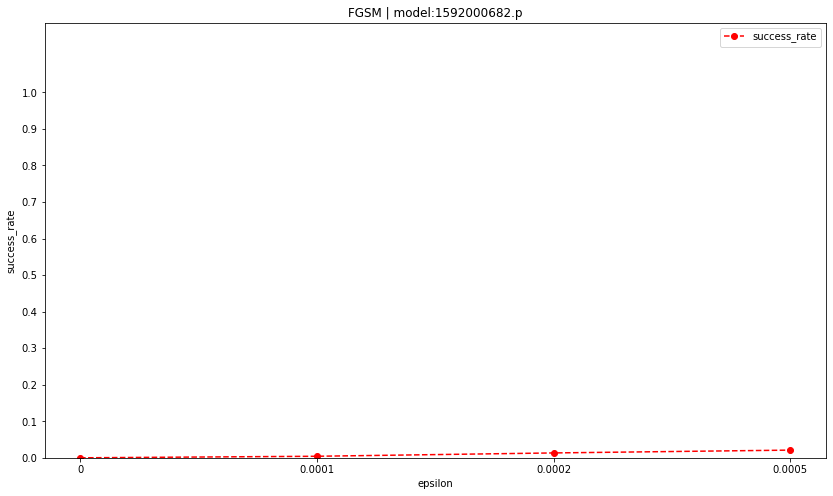

  0%|          | 0/27 [00:00<?, ?it/s]

Perform Attack #2/3: FGA L2


  0%|          | 0/27 [00:00<?, ?it/s]86s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 0}
Early stopping: 	False (-1)

Successfully attacked:	0
Total attacked: 	1427
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.85


  0%|          | 0/27 [00:00<?, ?it/s]87s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 1}
Early stopping: 	False (-1)

Successfully attacked:	282
Total attacked: 	1427
Total processed:	1687

Success-Rate: 		0.2
Perturbed Accurracy: 	0.68


 50%|█████     | 3/6 [00:11<00:11,  3.86s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 2}
Early stopping: 	False (-1)

Successfully attacked:	565
Total attacked: 	1427
Total processed:	1687

Success-Rate: 		0.4
Perturbed Accurracy: 	0.51


 67%|██████▋   | 4/6 [00:15<00:07,  3.91s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 5}
Early stopping: 	False (-1)

Successfully attacked:	990
Total attacked: 	1427
Total processed:	1687

Success-Rate: 		0.69
Perturbed Accurracy: 	0.26


 83%|████████▎ | 5/6 [00:19<00:03,  3.96s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 10}
Early stopping: 	False (-1)

Successfully attacked:	1211
Total attacked: 	1427
Total processed:	1687

Success-Rate: 		0.85
Perturbed Accurracy: 	0.13


100%|██████████| 6/6 [00:23<00:00,  3.95s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 20}
Early stopping: 	False (-1)

Successfully attacked:	1334
Total attacked: 	1427
Total processed:	1687

Success-Rate: 		0.93
Perturbed Accurracy: 	0.06


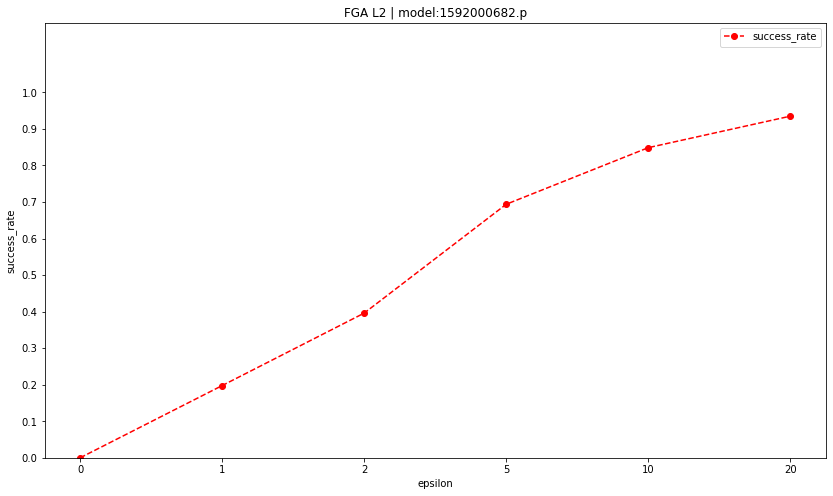

  0%|          | 0/27 [00:00<?, ?it/s]

Perform Attack #3/3: FGA L1


 17%|█▋        | 1/6 [00:03<00:19,  3.84s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 2000}
Early stopping: 	False (-1)

Successfully attacked:	1198
Total attacked: 	1427
Total processed:	1687

Success-Rate: 		0.84
Perturbed Accurracy: 	0.14


  0%|          | 0/27 [00:00<?, ?it/s]87s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 5000}
Early stopping: 	False (-1)

Successfully attacked:	1357
Total attacked: 	1427
Total processed:	1687

Success-Rate: 		0.95
Perturbed Accurracy: 	0.04


 50%|█████     | 3/6 [00:11<00:11,  3.88s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 10000.0}
Early stopping: 	False (-1)

Successfully attacked:	1345
Total attacked: 	1427
Total processed:	1687

Success-Rate: 		0.94
Perturbed Accurracy: 	0.05


  0%|          | 0/27 [00:00<?, ?it/s]92s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 20000.0}
Early stopping: 	False (-1)

Successfully attacked:	1289
Total attacked: 	1427
Total processed:	1687

Success-Rate: 		0.9
Perturbed Accurracy: 	0.08


 83%|████████▎ | 5/6 [00:19<00:03,  3.91s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 50000.0}
Early stopping: 	False (-1)

Successfully attacked:	1398
Total attacked: 	1427
Total processed:	1687

Success-Rate: 		0.98
Perturbed Accurracy: 	0.02


100%|██████████| 6/6 [00:23<00:00,  3.92s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 100000.0}
Early stopping: 	False (-1)

Successfully attacked:	1408
Total attacked: 	1427
Total processed:	1687

Success-Rate: 		0.99
Perturbed Accurracy: 	0.01


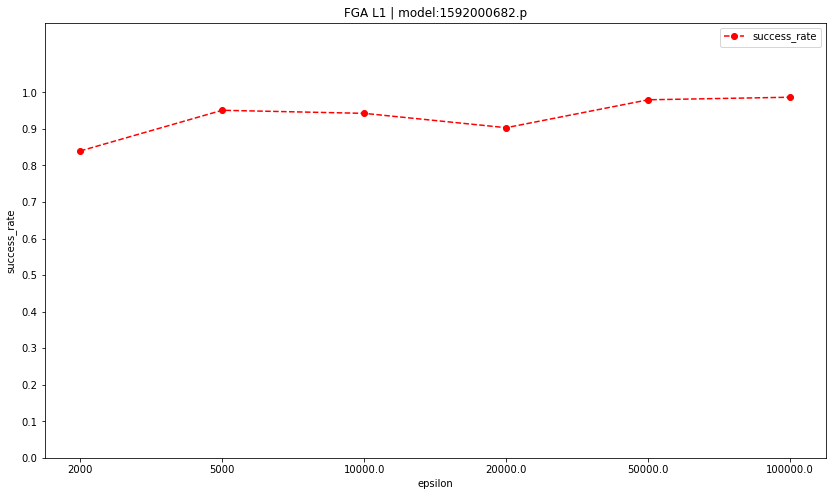

Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/4 [00:00<?, ?it/s]

Perform Attack #1/3: FGSM


  0%|          | 0/27 [00:00<?, ?it/s]92s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0}
Early stopping: 	False (-1)

Successfully attacked:	0
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.82


 50%|█████     | 2/4 [00:07<00:07,  3.89s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.0001}
Early stopping: 	False (-1)

Successfully attacked:	0
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.82


 75%|███████▌  | 3/4 [00:11<00:03,  3.92s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.0002}
Early stopping: 	False (-1)

Successfully attacked:	0
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.82


100%|██████████| 4/4 [00:15<00:00,  3.91s/it]


Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.0005}
Early stopping: 	False (-1)

Successfully attacked:	2
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.82


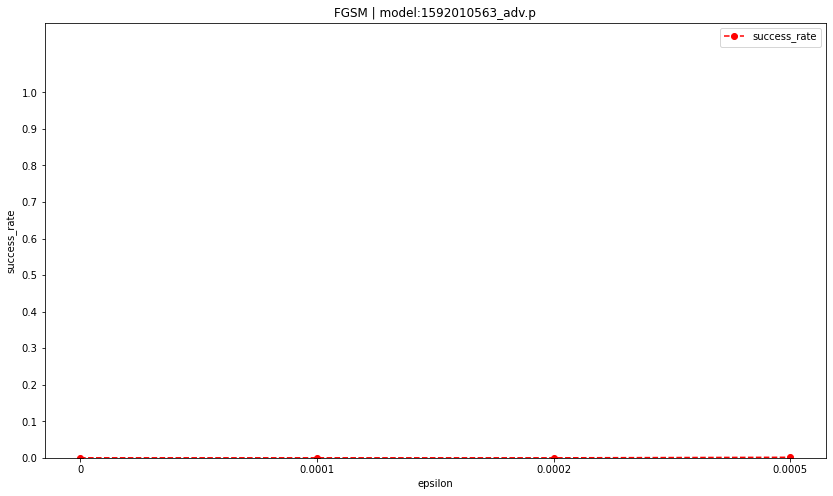

  0%|          | 0/6 [00:00<?, ?it/s]

Perform Attack #2/3: FGA L2


  0%|          | 0/27 [00:00<?, ?it/s]84s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 0}
Early stopping: 	False (-1)

Successfully attacked:	0
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.82


  0%|          | 0/27 [00:00<?, ?it/s]83s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 1}
Early stopping: 	False (-1)

Successfully attacked:	30
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.02
Perturbed Accurracy: 	0.81


  0%|          | 0/27 [00:00<?, ?it/s]82s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 2}
Early stopping: 	False (-1)

Successfully attacked:	54
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.04
Perturbed Accurracy: 	0.79


  0%|          | 0/27 [00:00<?, ?it/s]83s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 5}
Early stopping: 	False (-1)

Successfully attacked:	118
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.08
Perturbed Accurracy: 	0.75


  0%|          | 0/27 [00:00<?, ?it/s]82s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 10}
Early stopping: 	False (-1)

Successfully attacked:	222
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.16
Perturbed Accurracy: 	0.69


100%|██████████| 6/6 [00:22<00:00,  3.81s/it]


Attack-Parameters:	{'norm': '2', 'epsilon': 20}
Early stopping: 	False (-1)

Successfully attacked:	427
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.31
Perturbed Accurracy: 	0.57


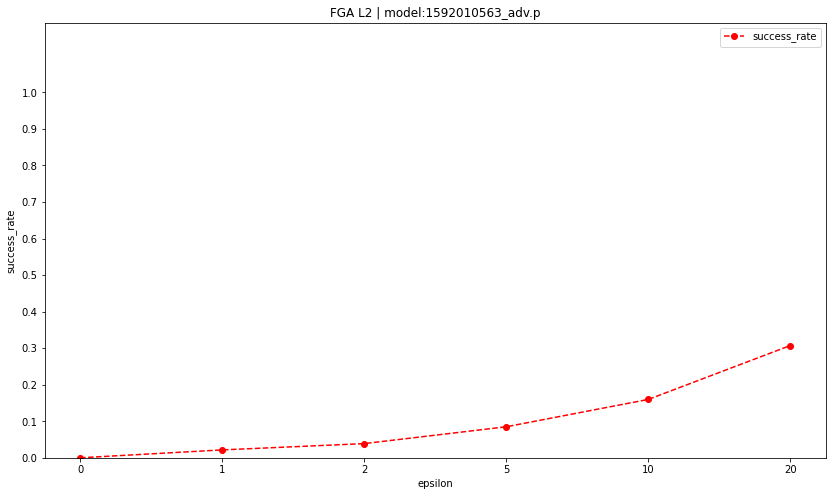

  0%|          | 0/6 [00:00<?, ?it/s]

Perform Attack #3/3: FGA L1


  0%|          | 0/27 [00:00<?, ?it/s]79s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 2000}
Early stopping: 	False (-1)

Successfully attacked:	210
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.15
Perturbed Accurracy: 	0.7


  0%|          | 0/27 [00:00<?, ?it/s]79s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 5000}
Early stopping: 	False (-1)

Successfully attacked:	503
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.36
Perturbed Accurracy: 	0.53


  0%|          | 0/27 [00:00<?, ?it/s]79s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 10000.0}
Early stopping: 	False (-1)

Successfully attacked:	901
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.65
Perturbed Accurracy: 	0.29


  0%|          | 0/27 [00:00<?, ?it/s]80s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 20000.0}
Early stopping: 	False (-1)

Successfully attacked:	975
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.7
Perturbed Accurracy: 	0.25


  0%|          | 0/27 [00:00<?, ?it/s]82s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 50000.0}
Early stopping: 	False (-1)

Successfully attacked:	775
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.56
Perturbed Accurracy: 	0.36


100%|██████████| 6/6 [00:22<00:00,  3.82s/it]


Attack-Parameters:	{'norm': '1', 'epsilon': 100000.0}
Early stopping: 	False (-1)

Successfully attacked:	773
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.56
Perturbed Accurracy: 	0.37


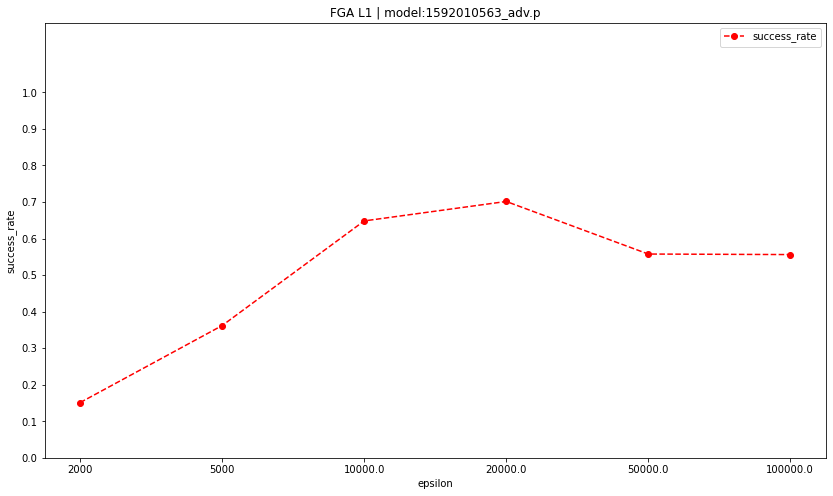

In [6]:
from utils.RobustnessExperiment import RobustnessExperiment
from attacks.FGA_Batch import fast_gradient_attack
from attacks.pgd import ProjectedGradientDescent

exp_config = [{
              "attack_fn": ProjectedGradientDescent, 
              "attack_arg": {"norm":["inf"], "epsilon": [0, 0.0001, 0.0002, 0.0005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 10]},
              "meta": {"key_result":"success_rate", "key_config":"epsilon", "title":"FGSM"}
             },
            {
            "attack_fn": ProjectedGradientDescent, 
            "attack_arg": {"norm":["2"], "epsilon": [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]},
            "meta": {"key_result":"success_rate", "key_config":"epsilon", "title":"FGA L2"}
            },
            {
            "attack_fn": ProjectedGradientDescent, 
            "attack_arg": {"norm":["1"], "epsilon": [100, 200, 500, 1000, 2000, 5000, 1e4, 2e4, 5e4, 1e5]},
            "meta": {"key_result":"success_rate", "key_config":"epsilon", "title":"FGA L1"}
            }]

experiment = RobustnessExperiment(exp_config, title="ProjectedGD L1+L2+FGSM")
experiment.run("./1592000682.p", M5PLModule) #20 epochs normal training with hparams above
experiment.run("./1592000852_adv.p", M5PLModule) #5 epochs adv training with hparams above
experiment.run("./1592007017_adv.p", M5PLModule) #20 epochs '' L2, 15 fixed
experiment.run("./1592008146_adv.p", M5PLModule) #50 epochs '' 
experiment.run("./1592010563_adv.p", M5PLModule) # 50 epochs, L1, 5000 fixed

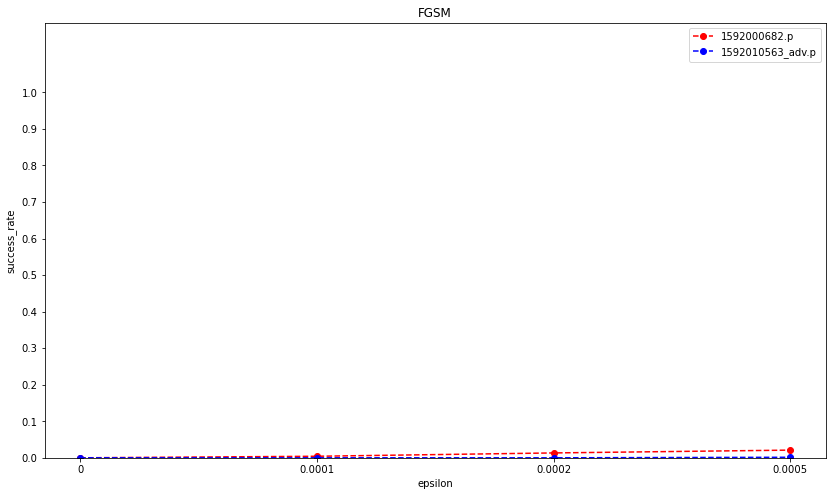

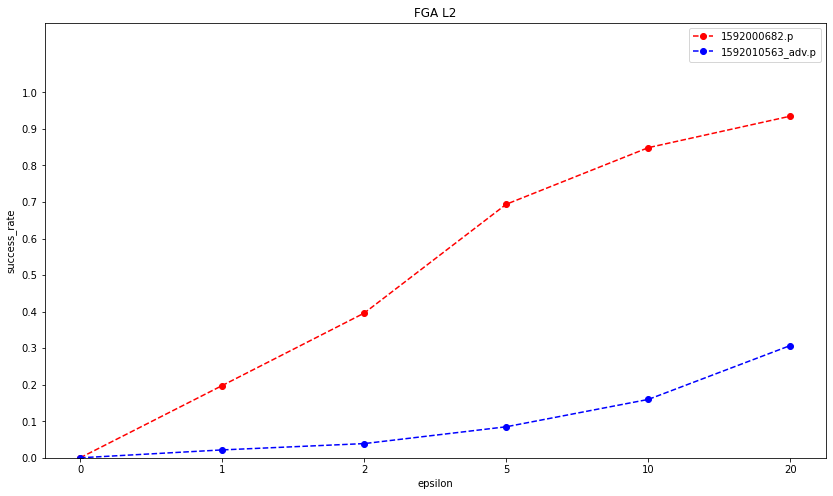

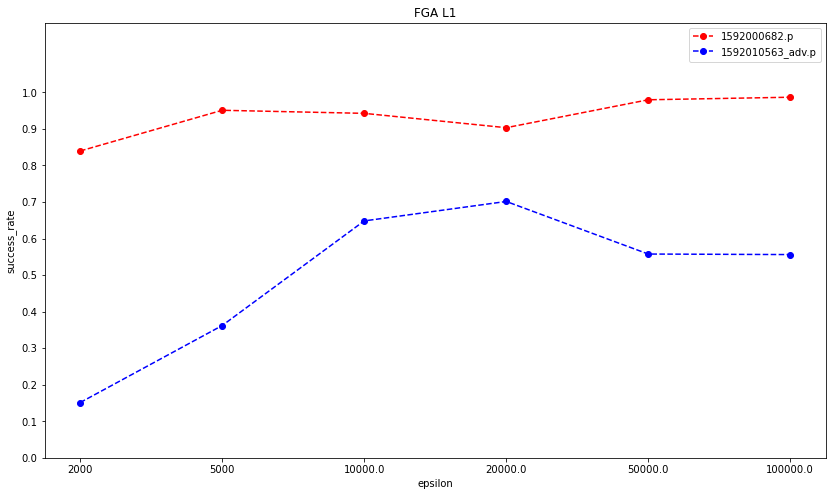

In [8]:
from utils.Visual import drawPlot

config_key = "epsilon"
results_key = "success_rate"

for i, attack in enumerate(experiment.all_results.keys()):
    xs = [ res[config_key] for res in experiment.all_results[attack]["CONFIGS"]] 
    vis_objects = []
    for m, model in enumerate(list(experiment.all_results[attack].keys())[1:]):
        ys = [ res[results_key] for res in experiment.all_results[attack][model]]
        vis_object = {"data": ys, "color" : "rbgycmk"[m], "label": model}
        vis_objects.append(vis_object)

    drawPlot(x = xs, data = vis_objects, x_label = config_key, y_label = results_key, 
             title = attack, 
             save_path = os.path.join(experiment.dir, "plot_comparison_{}.pdf".format(attack)))



In [10]:
experiment.all_results

{'FGSM': {'CONFIGS': [{'norm': 'inf', 'epsilon': 0},
   {'norm': 'inf', 'epsilon': 0.0001},
   {'norm': 'inf', 'epsilon': 0.0002},
   {'norm': 'inf', 'epsilon': 0.0005}],
  '1592000682.p': [{'success_rate': 0.0, 'acc': 0.8458802608180201},
   {'success_rate': 0.004204625087596356, 'acc': 0.8423236514522822},
   {'success_rate': 0.013314646110721794, 'acc': 0.8346176644931832},
   {'success_rate': 0.02102312543798178, 'acc': 0.8280972139893301}],
  '1592010563_adv.p': [{'success_rate': 0.0, 'acc': 0.8239478363959691},
   {'success_rate': 0.0, 'acc': 0.8239478363959691},
   {'success_rate': 0.0, 'acc': 0.8239478363959691},
   {'success_rate': 0.0014388489208633094, 'acc': 0.8227622999407231}]},
 'FGA L2': {'CONFIGS': [{'norm': '2', 'epsilon': 0},
   {'norm': '2', 'epsilon': 1},
   {'norm': '2', 'epsilon': 2},
   {'norm': '2', 'epsilon': 5},
   {'norm': '2', 'epsilon': 10},
   {'norm': '2', 'epsilon': 20}],
  '1592000682.p': [{'success_rate': 0.0, 'acc': 0.8458802608180201},
   {'success_

# ToDo

* adv training:
    * save training config for each model

* only run experiments have not been conducted yet
* load experiments

* compute sum or integral of curve, evaluation of large list of models
* provide nickname for each model
* adv training:
    * sample different epochs. / do checkpoints
    * optuna: what we optimize is the accuracy on FIXED (0.001, ...) epsilon set!!!



In [ ]:
experiment.run("./adv_training_results/trial#1_linf_adv.p", M5PLModule)